In [63]:
import os
import string
import re
import pandas as pd
import pickle
import sklearn.metrics as metrics #courbe roc
import matplotlib.pyplot as plt #courbe roc
import numpy as np
import random
from random import sample

os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

# Différentes fonctions utiles

In [64]:
#def choix():
#    return sample((1,-1),1)

def choix_aleatoire(corpus_train):
    random.seed(1)
    sentiments_tweets = [[tweet, score, sample((1,-1),1)[0]] for (score, tweet) in corpus_train]
    resultat = [[tweet, 1 if val == score else 0] for (tweet, score, val) in sentiments_tweets]
    return(sum(res for (tweet,res) in resultat)/len(resultat))

In [65]:
def sentiment_plus(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus+1,moins)
    
def sentiment_moins(mot, matrice_sentiments):
    plus, moins = matrice_sentiments[mot]
    matrice_sentiments[mot] = (plus,moins+1)

def mat_sentiments(corpus_train, vocabulaire):   
    #Initialisation
    matrice_sent = {mot:(0,0) for mot in vocabulaire}
    for (score, tweet) in corpus_train:
        for mot in tweet.split():
            if score == 1:
                sentiment_plus(mot, matrice_sent)
            else:
                sentiment_moins(mot,matrice_sent)
    matrice_sentiments_val = {mot:(matrice_sent[mot][0]-matrice_sent[mot][1])/((matrice_sent[mot][0]+matrice_sent[mot][1]))
                          for mot in vocabulaire}
    return matrice_sentiments_val

Deux manières de calculer le sentiment : 
- Tu regardes le % de tweets positifs dans lesquels il intervient => tu as un sentiment entre 0 et 1
- **approche retenue ici** Tu regardes (Nb tweets positifs - Nb tweets négatifs)/Nb tot de tweet => tu as un sentiment entre -1 et 1 

In [66]:
def sentiments_phrase(phrase,matrice_sentiments_val):
    somme = 0
    n = 0
    for mot in phrase.split():
        if mot in matrice_sentiments_val.keys():
            somme += matrice_sentiments_val[mot]
        n += 1
    if(n!=0):
        return(somme/n)
    else:
        return 0

In [67]:
# Proportion de tweets qui sont positifs. 
def proportion_positifs(resultat):  
    compteur = 0
    n = 0
    for (tweet, res) in resultat:
        n += 1
        if res == 1:
            compteur+=1
    return(compteur/n)

In [68]:
def eval(a,sentiments_tweets, resultat):
    resultat = [[tweet, 1 if ((val > a and score == 1) or (val < a and score == -1)) else 0]
            for (tweet, score, val) in sentiments_tweets]
    return sum(res for (tweet,res) in resultat)/len(resultat)

In [69]:
def resultat_final(corpus, matrice_sentiments_val):
    sentiments_tweets = [[tweet, score, sentiments_phrase(tweet, matrice_sentiments_val)] for (score, tweet) in corpus]
    resultat = [[tweet, 1 if ((val > 0 and score == 1) or (val < 0 and score == -1)) else 0]
            for (tweet, score, val) in sentiments_tweets]
    print("proportion_positifs :", proportion_positifs(resultat))
    res_final = {a/100:eval(a/100,sentiments_tweets, resultat) for a in range(-100,100)}
    return(res_final)

In [70]:
def courbe_roc(corpus,matrice_sentiments_val=None,methode=1):
    if methode==1:
        sentiments_tweets = [[tweet, score, choix()[0]] for (score, tweet) in corpus_train]
    if methode==2:
        sentiments_tweets = [[tweet, score, sentiments_phrase(tweet, matrice_sentiments_val)] for (score, tweet) in corpus]
        sentiments_tweets = [[tweet, score, 1 if (val > -0.05) else -1]
                for (tweet, score, val) in sentiments_tweets]
    preds = [res for (tweet, score, res) in sentiments_tweets] 
    Y_test = [score for (tweet, score, res) in sentiments_tweets] 
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    #plt.title('Courbe ROC - Régression logistique - Test')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show()

# Modèle 1 aléatoire : on prédit 1 ou -1 de manière random

## Application sur base git 

In [104]:
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train.file", "rb") as f:
    corpus_train = pickle.load(f)

In [106]:
print(choix_aleatoire(corpus_train))

0.50154


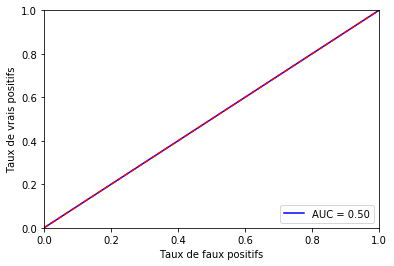

In [107]:
courbe_roc(corpus_train,methode=1)

## Application sur base sncf

In [110]:
with open("data/sentimental_analysis/corpus_test_sncf.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train_sncf.file", "rb") as f:
    corpus_train = pickle.load(f)

In [111]:
print(choix_aleatoire(corpus_train))

0.4969382654336416


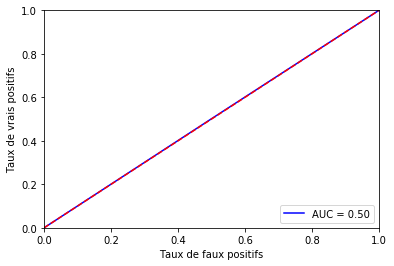

In [112]:
courbe_roc(corpus_train,methode=1)

# Modèle 2 : prédiction sentiment de la phrase en fonction du sentiment moyen des mots

## Application sur base git 

In [10]:
with open("data/sentimental_analysis/corpus_test.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train.file", "rb") as f:
    corpus_train = pickle.load(f)

In [11]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
print("Nombre de mots :", len(mots))
print("Taille du vocabulaire :", len(vocabulaire))

Nombre de mots : 674732
Taille du vocabulaire : 39650


In [12]:
matrice_sentiments_val = mat_sentiments(corpus_train, vocabulaire)
#print(matrice_sentiments_val["le"])
print(matrice_sentiments_val["gentil"])
print(matrice_sentiments_val["méchant"])
#sentiments_phrase("le gentil méchant", matrice_sentiments_val)

0.3333333333333333
-0.3448275862068966


In [13]:
# Enregistrement de la matrice_sentiment
with open("data/sentimental_analysis/matrice_sentiment_baseline_git.file", "wb") as f:
        pickle.dump(matrice_sentiments_val, f, pickle.HIGHEST_PROTOCOL)

Evaluation sur le train

In [84]:
res_final = resultat_final(corpus_train, matrice_sentiments_val)

proportion_positifs : 0.8441


Evaluation sur le test

In [85]:
res_final_test = resultat_final(corpus_test, matrice_sentiments_val)

proportion_positifs : 0.6986438975389252


Distributions test VS train

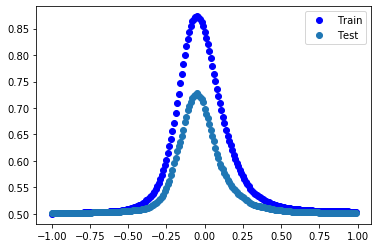

In [86]:
import matplotlib.pyplot as plt
import numpy as np

keys_train = np.fromiter(res_final.keys(), dtype=float)
vals_train = np.fromiter(res_final.values(), dtype=float)

keys_test = np.fromiter(res_final_test.keys(), dtype=float)
vals_test = np.fromiter(res_final_test.values(), dtype=float)

plt.plot(keys_train,vals_train,"bo")
plt.plot(keys_test,vals_test,'o')
plt.legend(["Train","Test"])

In [87]:
print("test :", [(key) for key in res_final_test.keys()
                 if res_final_test[key] == max(vals_test)])
print("train : ", [(key) for key in res_final.keys()
                   if res_final[key] == max(vals_train)])

test : [-0.05]
train :  [-0.05]


In [14]:
print(res_final[-0.05])
print(res_final_test[-0.05])

0.87328
0.7290306378704169


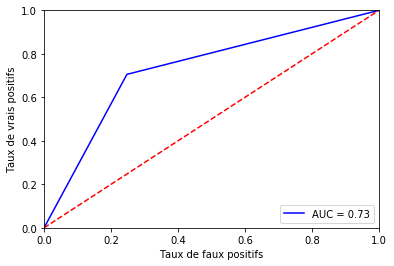

In [89]:
courbe_roc(matrice_sentiments_val,corpus_test,methode=2)

## Application sur base sncf

In [71]:
with open("data/sentimental_analysis/corpus_test_sncf.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train_sncf.file", "rb") as f:
    corpus_train = pickle.load(f)

In [32]:
len(corpus_test)+len(corpus_train)

22862

In [72]:
phrases = [tweet.split() for (score, tweet) in corpus_train]
mots = [item for sublist in phrases for item in sublist]
vocabulaire = list(dict.fromkeys(mots))
print("Nombre de mots :", len(mots))
print("Taille du vocabulaire :", len(vocabulaire))

Nombre de mots : 342106
Taille du vocabulaire : 26319


In [73]:
matrice_sentiments_val = mat_sentiments(corpus_train, vocabulaire)
#print(matrice_sentiments_val["le"])
print(matrice_sentiments_val["gentil"])
print(matrice_sentiments_val["méchant"])
#sentiments_phrase("le gentil méchant", matrice_sentiments_val)


0.8235294117647058
0.3333333333333333


In [21]:
# Enregistrement de la matrice_sentiment
with open("data/sentimental_analysis/matrice_sentiment_baseline_sncf.file", "wb") as f:
        pickle.dump(matrice_sentiments_val, f, pickle.HIGHEST_PROTOCOL)

Evaluation sur le train

In [75]:
res_final = resultat_final(corpus_train, matrice_sentiments_val)

proportion_positifs : 0.744063984003999


Evaluation sur le test

In [74]:
res_final_test = resultat_final(corpus_test, matrice_sentiments_val)

proportion_positifs : 0.705161854768154


Distributions test VS train

Text(0, 0.5, 'Accuracy')

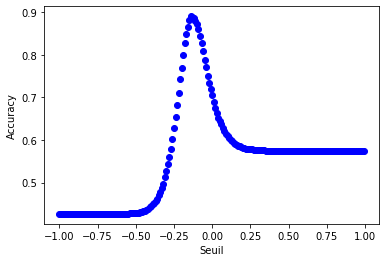

In [77]:
keys_train = np.fromiter(res_final.keys(), dtype=float)
vals_train = np.fromiter(res_final.values(), dtype=float)

keys_test = np.fromiter(res_final_test.keys(), dtype=float)
vals_test = np.fromiter(res_final_test.values(), dtype=float)

#plt.plot(keys_train,vals_train,"bo")
plt.plot(keys_test,vals_test,'bo')
plt.xlabel('Seuil')
plt.ylabel('Accuracy')
#plt.legend(["Train","Test"])

In [20]:
print("test :", [(key) for key in res_final_test.keys()
                 if res_final_test[key] == max(vals_test)])
print("train : ", [(key) for key in res_final.keys()
                   if res_final[key] == max(vals_train)])

test : [-0.14]
train :  [-0.14]


In [29]:
print(res_final[-0.14])
print(res_final_test[-0.14])

0.9502624343914021
0.8907844852726743


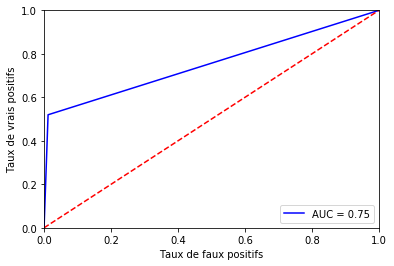

In [71]:
courbe_roc(matrice_sentiments_val,corpus_test)

In [78]:
matrice_sentiments_val["pas"]

-0.25299029564432407